## Fast.ai Deep Learning 1 Practice - Creating dataset from Google images

This notebook is practice for Lesson 2 of the [Fast.ai](https://www.fast.ai) course. 

In [1]:
from fastai.vision import *
import os

In [2]:
path = Path('/path/to/Datasets/bigcats/')

Go to [Google Images](images.google.com) and search for your desired class name (e.g. lion).
Use the javascript below to download the URLs for all of your images. Save the file as 'urls_nameofclass.csv', e.g. 'urls_lion.csv', in the parent directory of where you will store the folders for each class, not in each folder. (i.e. cats/urls_lion.csv NOT cats/lion/urls_lion.csv)

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [3]:
classes = ['lion', 'tiger', 'cheetah']

In [ ]:
# Replace the class in quotes for the name variable with the name of each or your classes
# Re-run only this cell for each of your classes (.csv files)
# The print(classes) below should show all of your classes
name = 'cheetah'

folder = name
file = 'urls_' + name + '.csv'
dest= path/folder
dest.mkdir(parents=True, exist_ok=True)
classes.append(name)

# Images will be download to a folder with the same name of your class
download_images(path/file, dest, max_pics=200)

In [4]:
print(classes)

['lion', 'tiger', 'cheetah']


In [5]:
# Verify that all the images can be opened, if not, they will be deleted
for img in classes:
    print(img)
    verify_images(path/img, delete=True, max_size=500)

lion


tiger


cheetah


## Viewing downloaded images

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=256, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

['cheetah', 'lion', 'tiger']

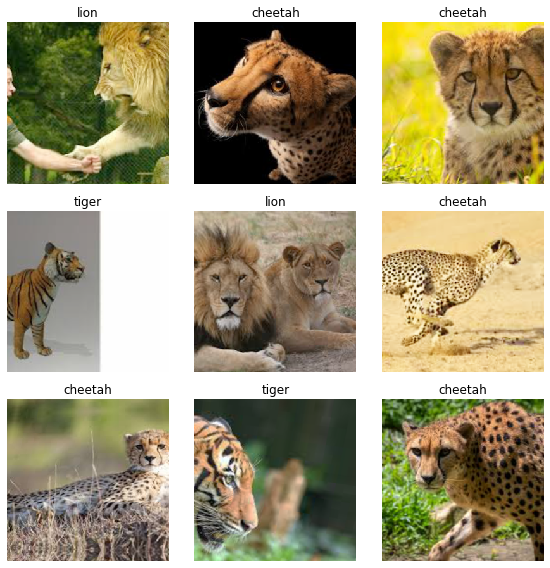

In [8]:
data.show_batch(rows=3, figsize=(8,8))

In [9]:
# Check the number of imaages in train and valid sets
# to make sure it split correctly
data.c, len(data.train_ds), len(data.valid_ds)

(3, 480, 120)

## Training model on resnet34

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.270358,0.121960,0.041667,00:04
1,0.675158,0.096949,0.016667,00:02
2,0.455841,0.101952,0.016667,00:02
3,0.335379,0.104091,0.025000,00:02


Model is already very accurate.

In [12]:
learn.save('stage1-34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


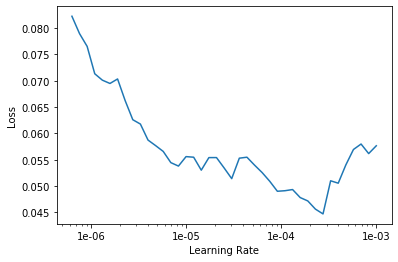

In [13]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.019125,0.093906,0.008333,00:02
1,0.026981,0.094304,0.008333,00:02


Error rate is now even lower at 0.00833.

In [18]:
learn.save('stage2-34')

In [19]:
learn.load('stage2-34');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

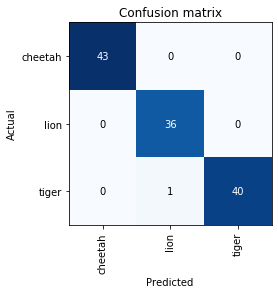

In [21]:
interp.plot_confusion_matrix()

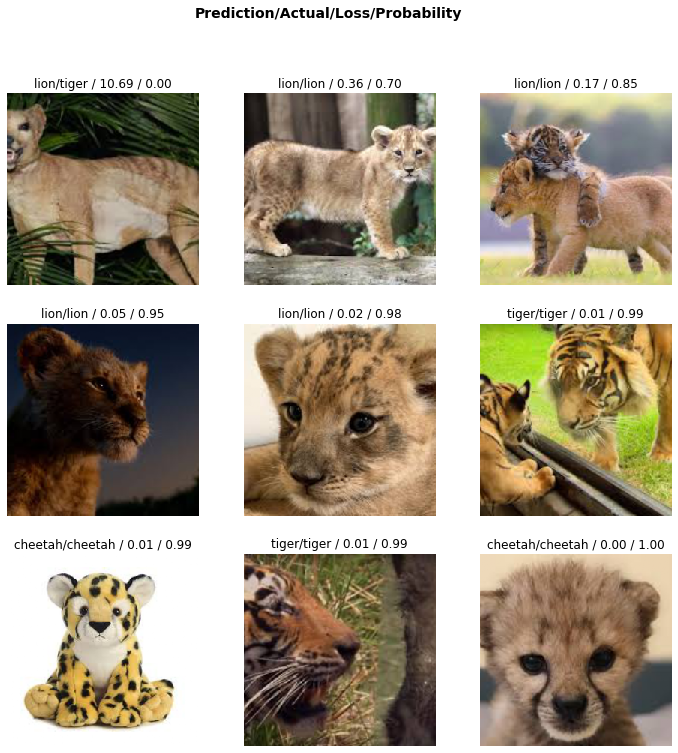

In [22]:
interp.plot_top_losses(9)

In [24]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=256)
                   .databunch()
     )

## Trying to improve further

Training again with same settings as before after manually pruning top losses.

In [32]:
learn_clean = cnn_learner(db, models.resnet34, metrics=error_rate)

In [33]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.028482,0.209443,0.016667,00:02
1,0.047816,0.131312,0.008333,00:02


Error rate didn't decrease further but still a very good model.